# Sec Financial Statement Data Sets Tools - Quickstart

## TL;DR

This notebook gives a first introduction into using the secfsdstools (Sec Financial Data Sets Tools) python package: https://pypi.org/project/secfsdstools/

It is designed to work with the data provided by the "Sec Financial Statement Data Sets" (SFSDS)(https://www.sec.gov/dera/data/financial-statement-data-sets).

The SFSDS contains data from all reports that were filed with the SEC since 2012. For instance all annual and quarterly reports. The main assets that can be retrieved from this data set are the financial statemens (balance sheet, income statement, and cash flow).

First, this notebook shows how the library is installed and configured. After that, it shows the different ways how the financial statements can be extracted from the data set.

For a detailed definition of the data set see https://www.sec.gov/files/financial-statement-data-sets.pdf.

## Principles / Concepts

The goal is bulk processing of the data.

To improve efficiency, the zip files are downloaded and indexed using a SQLite database table.
The index table contains information on all filed reports, over 500,000 in total. The first
download of the data will take a couple of minutes but after that, all the data is on your local harddisk
and new data will only be donwloaded every quarter.

Using the index in the sqlite db allows for direct extraction of data for a specific report from the
appropriate zip file, reducing the need to open and search through each zip file.

Moreover, the downloaded zip files are converted to the parquet format which provides faster read access
to the data compared to reading the csv files inside the zip files and still providing a similar 
compress ratio than zip.

The library is designed to have a low memory footprint.

## Installation
In order to install the library, just use pip install:
```
pip install secfsdstools
```

## Configure logging in Jupyter

In [1]:
# to ensure that the logging statements are shown in juypter output, run this cell
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Configure table output for Pandas

In [2]:
import pandas as pd
# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_rows', 500) # ensure that all rows are shown
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width',1000)

## Configuration / Setup

In order to be used, the library needs to know where to store the compressed files from the Financial Statement Data Sets and where to store the sqlite database file. This is configured in a configuration file.

If you don't provide a config file, one will be created the first time you use the api. The configuration file will be created inside your home
directory. You can then change the content of it or directly start with the downloading of the data.

```
[DEFAULT]
downloaddirectory = <userhome>/secfsdstools/data/dld
parquetdirectory = <userhome>/secfsdools/data/parquet
dbdirectory = <userhome>/secfsdstools/data/db
useragentemail = your.email@goeshere.com
```

The downloaddirectory is the folder in which the compressed data files are downloaded.
The parquetdirectory is the folder in which the transfomred parquet version is stored.
The dbdirectory will contain sqlite db file.
The useragentemail is set inside the header when requests to sec.gov are made. This should be your email-address, however, since we are only making very few requests, it doesn't really matter if you change it or not.

If you want to start the download of the data "manually", just call the update method. However, the framework also checks at most every 24 hours if there is new data available and automatically downloads it.

In [3]:
from secfsdstools.update import update

update()

2025-02-12 06:18:40,204 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-12 06:18:40,854 [INFO] updateprocess  Launching data update process ...
2025-02-12 06:18:40,879 [INFO] task_framework  Starting process SecDownloadingProcess
2025-02-12 06:18:40,882 [INFO] secdownloading_process  reading table in main page: https://www.sec.gov/dera/data/financial-statement-data-sets.html
2025-02-12 06:18:41,310 [INFO] task_framework  Starting process ToParquetTransformerProcess
2025-02-12 06:18:41,311 [INFO] task_framework  Starting process ReportParquetIndexerProcess


The following tasks will be executed:
1. All currently available zip-files are downloaded form sec.gov (these are over 50 files that will need over 7 GB of space on your local drive)
2. All the zipfiles are transformed and stored as parquet files. Per default, the zipfile is deleted afterwards. If you want to keep the zip files, set the parameter 'KeepZipFiles' in the config file to True.
3. An index inside a sqlite db file is created

The first download may take about 20 minutes.

If you don't call update "manually", then the first time you call a function from the library, a download will be triggered.

Moreover, at most once a day, the framework checks if there is a new zip file available on sec.gov. If there is, a download will be started automatically. 
If you don't want 'auto-update', set the 'AutoUpdate' in your config file to False.
The new quarter zip files are available by the beginning of every quarter (January, April, July, October), hence, yo have to run the update() at the beginning of every quarter to get the data for the reprots from last quarter.

**Note:** the first time downloading data will take a couple of minutes (>15 minutes), since over 7 GB of data will be downloaded and converted into parquet format.

**Note:** if you only keep the transformed parquet data (which is the default configuration), you need about 5.5GB as per January 2025

**Note: If you plan to use Jupyter, make sure that you configure the directories at a location where your Jupyter process has access. The used default directory (your user home directory) will work.**

## A first simple example
Goal: present the information in the balance sheet of Apple's 2022 10-K report in the same way as it appears in the
original report on page 31 ("CONSOLIDATED BALANCE SHEETS"): https://www.sec.gov/ix?doc=/Archives/edgar/data/320193/000032019322000108/aapl-20220924.htm

**Note:** Version 2 of the framework supports now the `segments` that was introduced in January 2025. By adjusting the parameter `show_segments` you can define whether the segments information are shown or not


In [4]:
from secfsdstools.e_collector.reportcollecting import SingleReportCollector
from secfsdstools.e_filter.rawfiltering import ReportPeriodAndPreviousPeriodRawFilter
from secfsdstools.e_presenter.presenting import StandardStatementPresenter

# the unique identifier for apple's 10-K report of 2022
apple_10k_2022_adsh = "0000320193-22-000108"

# us a Collector to grab the data of the 10-K report. filter for balancesheet information
collector: SingleReportCollector = SingleReportCollector.get_report_by_adsh(
      adsh=apple_10k_2022_adsh,
      stmt_filter=["BS"]
)  
rawdatabag = collector.collect() # load the data from the disk
  
bs_df = (rawdatabag
         # ensure only data from the period (2022) of the previous period (2021) is in the data
         .filter(ReportPeriodAndPreviousPeriodRawFilter())
         # join the the content of the pre_txt and num_txt together
         .join()  
         # format the data in the same way as it appears in the report
         .present(StandardStatementPresenter(show_segments=False))) 
print(bs_df) 

2025-02-12 06:18:47,877 [INFO] __init__  loading secfsdstools ...
2025-02-12 06:18:47,879 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-12 06:18:47,946 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


                    adsh coreg                                              tag       version stmt  report  line segments     uom  negating  inpth  qrtrs_0/20220930  qrtrs_0/20210930
0   0000320193-22-000108                  CashAndCashEquivalentsAtCarryingValue  us-gaap/2022   BS       5     3              USD         0      0      2.364600e+10      3.494000e+10
1   0000320193-22-000108                            MarketableSecuritiesCurrent  us-gaap/2022   BS       5     4              USD         0      0      2.465800e+10      2.769900e+10
2   0000320193-22-000108                           AccountsReceivableNetCurrent  us-gaap/2022   BS       5     5              USD         0      0      2.818400e+10      2.627800e+10
3   0000320193-22-000108                                           InventoryNet  us-gaap/2022   BS       5     6              USD         0      0      4.946000e+09      6.580000e+09
4   0000320193-22-000108                             NontradeReceivablesCurrent  us-g

## Overview
The following diagram gives an overview on SECFSDSTools library.

![Overview](https://github.com/HansjoergW/sec-fincancial-statement-data-set/raw/main/docs/images/overview.png)

It mainly exists out of two main processes. The first one ist the "Date Update Process" wich is responsible for the
download of the Financial Statement Data Sets zip files from the sec.gov website, transforming the content into parquet
format, and indexing the content of these files in a simple SQLite database. Again, this whole process can be started
"manually" by calling the update method, or it is done automatically, as it is described above.

The second main process is the "Data Processing Process", which is working with the data that is stored inside the
sub.txt, pre.txt, and num.txt files from the zip files. The "Data Processing Process" mainly exists out of four steps:

* **Collect** <br/> Collect the rawdata from one or more different zip files. For instance, get all the data for a single
report, or get the data for all 10-K reports of a single report from several zip files.
* **Raw Processing** <br/> Once the data is collected, the collected data for sub.txt, pre.txt, and num.txt is available
as a pandas dataframe. Filters can be applied, the content can directly be saved and loaded.
* **Joined Processing** <br/> From the "Raw Data", a "joined" representation can be created. This joins the data from
the pre.txt and num.txt content together based on the "adhs", "tag", and "version" attributes. "Joined data" can also be
filtered, concatenated, directly saved and loaded.
* **Present** <br/> Produce a single pandas dataframe out of the data and use it for further processing or produce standardized views on Balance Sheets, Income Statements, and Cash Flow.

The diagramm also shows the main classes with which a user interacts. The use of them  is described in the following chapters.


## General
Most of the classes you interact with have a factory method which name starts with "get_". All these factory methods
take at least one **optional** parameter called configuration which is of type "Configuration".

If you do not provide this parameter, the class will read the configuration info from you configuration file in your home
directory. If, for whatever reason, you do want to provide an alternative configuration, you can overwrite it.

However, normally you do not have to provide the "configuration" parameter.

## Index: working with the index
The first class that interacts with the index is the `IndexSearch` class. It provides a single method `find_company_by_name`
which executes a SQL Like search on the name of the available companies and returns a pandas dataframe with the columns
'name' and 'cik' (the central index key, or the unique id of a company in the financial statements data sets).
The main purpose of this class is to find the cik for a company (of course, you can also directly search the cik on https://www.sec.gov/edgar/searchedgar/companysearch).

In [8]:
from secfsdstools.c_index.searching import IndexSearch

index_search = IndexSearch.get_index_search()
results = index_search.find_company_by_name("apple")
print(results)

2025-02-01 07:11:32,192 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


                             name      cik
0       APPLE GREEN HOLDING, INC.  1510976
1    APPLE HOSPITALITY REIT, INC.  1418121
2                       APPLE INC   320193
3       APPLE ISPORTS GROUP, INC.  1134982
4          APPLE REIT EIGHT, INC.  1387361
5           APPLE REIT NINE, INC.  1418121
6          APPLE REIT SEVEN, INC.  1329011
7              APPLE REIT SIX INC  1277151
8            APPLE REIT TEN, INC.  1498864
9          APPLETON PAPERS INC/WI  1144326
10  DR PEPPER SNAPPLE GROUP, INC.  1418135
11   MAUI LAND & PINEAPPLE CO INC    63330
12          PINEAPPLE ENERGY INC.    22701
13  PINEAPPLE EXPRESS CANNABIS CO  1710495
14        PINEAPPLE EXPRESS, INC.  1654672
15       PINEAPPLE FINANCIAL INC.  1938109
16                PINEAPPLE, INC.  1654672


Once you have the cik of a company, you can use the `CompanyIndexReader` to get information on available reports of a company.
To get an instance of the class, you use the get `get_company_index_reader` method and provide the cik parameter.

In [9]:
from secfsdstools.c_index.companyindexreading import CompanyIndexReader

apple_cik = 320193
apple_index_reader = CompanyIndexReader.get_company_index_reader(cik=apple_cik)

2025-02-01 07:11:48,999 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


First, you could use the method `get_latest_company_filing` which returns a dictionary with the latest filing of the company:

In [10]:
print(apple_index_reader.get_latest_company_filing())

{'adsh': '0000320193-24-000123', 'cik': 320193, 'name': 'APPLE INC', 'sic': 3571.0, 'countryba': 'US', 'stprba': 'CA', 'cityba': 'CUPERTINO', 'zipba': '95014', 'bas1': 'ONE APPLE PARK WAY', 'bas2': None, 'baph': '(408) 996-1010', 'countryma': 'US', 'stprma': 'CA', 'cityma': 'CUPERTINO', 'zipma': '95014', 'mas1': 'ONE APPLE PARK WAY', 'mas2': None, 'countryinc': 'US', 'stprinc': 'CA', 'ein': 942404110, 'former': 'APPLE INC', 'changed': 20070109.0, 'afs': '1-LAF', 'wksi': 1, 'fye': '0930', 'form': '10-K', 'period': 20240930, 'fy': 2024.0, 'fp': 'FY', 'filed': 20241101, 'accepted': '2024-11-01 06:02:00.0', 'prevrpt': 0, 'detail': 1, 'instance': 'aapl-20240928_htm.xml', 'nciks': 1, 'aciks': None}


Next there are two methods which return the metadata of the reports that a company has filed. The result is either
returned as a list of `IndexReport` instances, if you use the method `get_all_company_reports` or as pandas dataframe if
you use the method `get_all_company_reports_df`. Both method can take an optional parameter `forms`, which defines the
type of the report that is returned. For instance, if you are only interested in the annual and quarterly reports,
set forms to `["10-K", "10-Q"]`.

In [11]:
# only show the annual reports of apple
print(apple_index_reader.get_all_company_reports_df(forms=["10-K"]))

                    adsh     cik       name  form     filed    period                                                     fullPath  originFile originFileType                                                                                               url
0   0000320193-24-000123  320193  APPLE INC  10-K  20241101  20240930  C:\Users\hansj\secfsdstools\data\parquet\quarter\2024q4.zip  2024q4.zip        quarter  https://www.sec.gov/Archives/edgar/data/320193/000032019324000123/0000320193-24-000123-index.htm
1   0000320193-23-000106  320193  APPLE INC  10-K  20231103  20230930  C:\Users\hansj\secfsdstools\data\parquet\quarter\2023q4.zip  2023q4.zip        quarter  https://www.sec.gov/Archives/edgar/data/320193/000032019323000106/0000320193-23-000106-index.htm
2   0000320193-22-000108  320193  APPLE INC  10-K  20221028  20220930  C:\Users\hansj\secfsdstools\data\parquet\quarter\2022q4.zip  2022q4.zip        quarter  https://www.sec.gov/Archives/edgar/data/320193/000032019322000108/0000320

**Note:** the entries in the url column above directly open the filing of that report on the sec.gov website.

## Collect: collecting the data from reports
The previously introduced `IndexSearch` and `CompanyIndexReader` let you know what data is available, but they do not
return the real data of the financial statements. This is what the `Collector` classes are used for.

All the `Collector` classes have their own factory method(s) which instantiate the class. Most of these factory methods
also provide parameters to filter the data directly when being loaded from the parquet files.
These are
* the `forms_filter` <br> lets you select which report type should be loaded (e.g. "10-K" or "10-Q").<br>
  Note: the `forms` filter affects all dataframes (sub, pre, num).
* the `stmt_filter` <br> defines the statements that should be loaded (e.g., "BS" if only "Balance Sheet" data should be loaded) <br>
  Note: the stmt filter only affects the pre dataframe.
* the `tag_filter` <br> defines the tags, that should be loaded (e.g., "Assets" if only the "Assets" tag should be loaded) <br>
  Note: the tag filter affects the pre and num dataframes.

It is also possible to apply filter for these attributes after the data is loaded, but since the `Collector` classes
apply these filters directly during the load process from the parquet files (which means that fewer data is loaded from
the disk) they are generally more efficient.

All `Collector` classes have a `collect` method which then loads the data from the parquet files and returns an instance
of `RawDataBag`. The `RawDataBag` instance contains then three pandas dataframe: one for the `sub` (subscription) data,
one for the `pre` (presentation) data, and one for the `num` (the numeric values) data.

The framework provides the following collectors:

---
* `SingleReportCollector` <br> As the name suggests, this `Collector` returns the data of a single report. It is 
  instantiated by providing the `adsh` of the desired report as parameter of the `get_report_by_adsh` factory method, 
  or by using an instance of the `IndexReport` as parameter of the `get_report_by_indexreport`. (As a reminder: 
  instances of `IndexReport` are returned by the `CompanyIndexReader` class).

In [15]:
from secfsdstools.e_collector.reportcollecting import SingleReportCollector

apple_10k_2022_adsh = "0000320193-22-000108"

collector: SingleReportCollector = SingleReportCollector.get_report_by_adsh(adsh=apple_10k_2022_adsh)
rawdatabag = collector.collect()

# as expected, there is just one entry in the submission dataframe
print(rawdatabag.sub_df)
print('\n-------------------------------------------------')

# just print the first 10 rows of the pre and num dataframes
print(rawdatabag.pre_df[:10])
print('\n-------------------------------------------------')
print(rawdatabag.num_df[:10])

2025-02-01 07:16:51,465 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


                   adsh     cik       name     sic countryba stprba     cityba  zipba                bas1  bas2            baph countryma stprma     cityma  zipma                mas1  mas2 countryinc stprinc        ein     former     changed    afs  wksi   fye  form    period      fy  fp     filed               accepted  prevrpt  detail               instance  nciks aciks
0  0000320193-22-000108  320193  APPLE INC  3571.0        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None  (408) 996-1010        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None         US      CA  942404110  APPLE INC  20070109.0  1-LAF     1  0930  10-K  20220930  2022.0  FY  20221028  2022-10-27 18:01:00.0        0       1  aapl-20220924_htm.xml      1  None

-------------------------------------------------
                   adsh  report  line stmt  inpth rfile                                                                                          tag       version                                    p

---
* `MultiReportCollector` <br> Contrary to the `SingleReportCollector`, this `Collector` can collect data from several
  reports. Moreover, the data of the reports are loaded in parallel, this  especially improves the performance if the
  reports are from different quarters (resp. are in different zip files). The class provides the factory methods 
  `get_reports_by_adshs` and `get_reports_by_indexreports`. The first takes a list of adsh strings, the second a list
  of `IndexReport` instances.

In [16]:
from secfsdstools.e_collector.multireportcollecting import MultiReportCollector
apple_10k_2022_adsh = "0000320193-22-000108"
apple_10k_2012_adsh = "0001193125-12-444068"

# load only the assets tags that are present in the 10-K report of apple in the years
# 2022 and 2012
collector: MultiReportCollector = MultiReportCollector.get_reports_by_adshs(
                                              adshs=[apple_10k_2022_adsh, apple_10k_2012_adsh],
                                              tag_filter=['Assets'])
rawdatabag = collector.collect()
# as expected, there are just two entries in the submission dataframe
print(rawdatabag.sub_df, '\n')
print(rawdatabag.num_df)  

2025-02-01 07:17:51,200 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-01 07:17:51,203 [INFO] parallelexecution      items to process: 2
2025-02-01 07:17:53,612 [INFO] parallelexecution      commited chunk: 0


                   adsh     cik       name     sic countryba stprba     cityba  zipba                bas1  bas2            baph countryma stprma     cityma  zipma                mas1  mas2 countryinc stprinc          ein              former     changed    afs  wksi   fye  form    period      fy  fp     filed               accepted  prevrpt  detail               instance  nciks aciks
0  0000320193-22-000108  320193  APPLE INC  3571.0        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None  (408) 996-1010        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None         US      CA  942404110.0           APPLE INC  20070109.0  1-LAF     1  0930  10-K  20220930  2022.0  FY  20221028  2022-10-27 18:01:00.0        0       1  aapl-20220924_htm.xml      1  None
1  0001193125-12-444068  320193  APPLE INC  3571.0        US     CA  CUPERTINO  95014   ONE INFINITE LOOP  None  (408) 996-1010        US     CA  CUPERTINO  95014   ONE INFINITE LOOP  None         US      CA  942404110.0  APPLE 

---
* `ZipCollector` <br> This `Collector` collects the data of one single zip (resp. the folder that contains the parquet
  files of this zip file). And since the original zip file contains the data for one quarter, the name you provide
  in the `get_zip_by_name` factory method reflects the quarter which data you want to load: e.g. `2022q1.zip`.

In [17]:
from secfsdstools.e_collector.zipcollecting import ZipCollector

# only collect the Balance Sheet of annual reports that
# were filed during the first quarter in 2022
collector: ZipCollector = ZipCollector.get_zip_by_name(name="2022q1.zip",
                                                       forms_filter=["10-K"],
                                                       stmt_filter=["BS"])

rawdatabag = collector.collect()

# only show the size of the data frame
# .. over 4000 companies filed a 10 K report in q1 2022
print(rawdatabag.sub_df.shape)
print(rawdatabag.pre_df.shape)
print(rawdatabag.num_df.shape)    

2025-02-01 07:18:57,113 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-01 07:18:57,116 [INFO] parallelexecution      items to process: 1
2025-02-01 07:18:57,117 [INFO] zipcollecting  processing C:\Users\hansj\secfsdstools\data\parquet\quarter\2022q1.zip
2025-02-01 07:18:58,845 [INFO] parallelexecution      commited chunk: 0


(4862, 36)
(183226, 10)
(2217834, 10)


---
* `CompanyReportCollector` <br> This class returns reports for one or more companies. The factory method 
  `get_company_collector` provides the parameter `ciks` which takes a list of cik numbers.

In [18]:
from secfsdstools.e_collector.companycollecting import CompanyReportCollector

apple_cik = 320193
# load the data for all 10-K (annual) reports of apple
collector = CompanyReportCollector.get_company_collector(ciks=[apple_cik],
                                                         forms_filter=["10-K"])

rawdatabag = collector.collect()

# all filed 10-K reports for apple since 2010 are in the databag
print(rawdatabag.sub_df)

print(rawdatabag.pre_df.shape)
print(rawdatabag.num_df.shape) 

2025-02-01 07:19:34,280 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-01 07:19:34,482 [INFO] parallelexecution      items to process: 16
2025-02-01 07:19:41,020 [INFO] parallelexecution      commited chunk: 0


                    adsh     cik       name     sic countryba stprba     cityba  zipba                bas1  bas2            baph countryma stprma     cityma  zipma                mas1  mas2 countryinc stprinc          ein              former     changed    afs  wksi   fye  form    period      fy  fp     filed               accepted  prevrpt  detail                  instance  nciks aciks
0   0000320193-24-000123  320193  APPLE INC  3571.0        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None  (408) 996-1010        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None         US      CA  942404110.0           APPLE INC  20070109.0  1-LAF     1  0930  10-K  20240930  2024.0  FY  20241101  2024-11-01 06:02:00.0        0       1     aapl-20240928_htm.xml      1  None
1   0000320193-23-000106  320193  APPLE INC  3571.0        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None  (408) 996-1010        US     CA  CUPERTINO  95014  ONE APPLE PARK WAY  None         US      CA  942404110.

## Raw Processing: working with the raw data
When the `collect` method of a `Collector` class is called, the data for the sub, pre, and num dataframes are loaded
and being stored in the sub_df, pre_df, and num_df attributes inside an instance of `RawDataBag`.

The `RawDataBag` provides the following methods:
* `save`, `load`<br> The content of a `RawDataBag` can be saved into a directory. Within that directory, 
   parquet files are stored for the content of the sub_df, pre_df, and num_df. In order to load this 
   data directly, the static method `RawDataBag.load()` can be used.
* `concat`<br> Several instances of a `RawDataBag` can be concatenated in one single instance. In order to do 
   that, the static method `RawDataBag.concat()` takes a list of RawDataBag as parameter.
* `join` <br> This method produces a `JoinedRawDataBag` by joining the content of the pre_df and num_df
   based on the columns adsh, tag, and version. It is an inner join. The joined dataframe appears as pre_num_df in
   the `JoinedRawDataBag`.
* `filter` <br> The filter method takes a parameter of the type `FilterRaw`, applies it to the data and
   produces a new instance of `RawDataBag` with the filtered data. Therefore, filters can also be chained like
   `a_filtered_RawDataBag = a_RawDataBag.filter(filter1).filter(filter2)`. Moreover, the `__get__item` method
   is forwarded to the filter method, so you can also write `a_filtered_RawDataBag = a_RawDataBag[filter1][filter2]`.

It is simple to write your own filters, just get some inspiration from the once that are already present in the
Framework (module `secfsdstools.e_filter.rawfiltering`:

* `AdshRawFilter` <br> Filters the `RawDataBag` instance based on the list of adshs that were provided in the constructor. <br>
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(AdshRawFilter(adshs=['0001193125-09-214859', '0001193125-10-238044']))
   ````
* `StmtRawFilter` <br> Filters the `RawDataBag`instance based on the list of statements ('BS', 'CF', 'IS', ...). <br>
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(StmtRawFilter(stmts=['BS', 'IS']))
   ````
* `TagRawFilter` <br> Filters the `RawDataBag`instance based on the list of tags that is provided. <br>
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(TagRawFilter(tags=['Assets', 'Liabilities']))
   ````
* `MainCoregRawFilter` <br> Filters the `RawDataBag` so that data of subsidiaries are removed.
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(MainCoregRawFilter()) 
   ````
* `ReportPeriodAndPreviousPeriodRawFilter` <br> The data of a report usually also contains data from previous years.
  However, often you want just to analyze the data of the current and the previous year. This filter ensures that
  only data for the current period and the previous period are contained in the data.
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(ReportPeriodAndPreviousPeriodRawFilter()) 
   ````
* `ReportPeriodRawFilter` <br> If you are just interested only in the data of a report that is from the current period
  of the report then you can use this filter. For instance, if you use a `CompanyReportCollector` to collect all
  10-K reports of this company, you want to ensure that every report only contains data for its period and not for
  previous periods.
   ````
   a_filtered_RawDataBag = a_RawDataBag.filter(ReportPeriodRawFilter()) 
   ````
* `OfficialTagsOnlyRawFilter` <br> Sometimes companies report some data points with unofficial tags, meaning they are not defined
  in the US-GAAP XBLR definition. Or they use an existing official tag name, but do not follow the definition of it. This filter makes
  sure that only real US-GAAP XBRL tags are returned. Note: not official tags have the `adsh` number set as `version`.
  ````
   a_filtered_RawDataBag = a_RawDataBag.filter(OfficialTagsOnlyRawFilter()) 
  ````
* `USDOnlyRawFilter` <br> Most of the datapoints are reported in USD. However, international companies often report certain data points
  not only in USD, but also in other currencies. If you use this filter, you will get data points only for USD.
  ````
   a_filtered_RawDataBag = a_RawDataBag.filter(USDOnlyRawFilter()) 
  ```` 
* `NoSegmentInfoRawFilter` <br> Filters for rows in the num dataframe which do not contain values in the segments column.
  ````
   a_filtered_RawDataBag = a_RawDataBag.filter(NoSegmentInfoRawFilter()) 
  ```` 
  

## Joined Processing: working with joined data
When the `join` method of a `RawDataBag` instance is called an instance of `JoinedDataBag` is returned. The returned
instance contains an attribute sub_df, which is a reference to the same sub_df that is in the `RawDataBag`.
In addition to that, the `JoinedDataBag` contains an attribut pre_num_df, which is an inner join of the pre_df and 
the num_df based on the columns adsh, tag, and version. Note that an entry in the pre_df can be joined with more than 
one entry in the num_df.

The `JoinedDataBag` provides the following methods:
* `save`, `load`<br> The content of a `JoinedDataBag` can be saved into a directory. Within that directory,
  parquet files are stored for the content of the sub_df, pre_df, and num_df. In order to load this
  data directly, the static method `JoinedDataBag.save()` can be used.
* `concat`<br> Several instances of a `JoinedDataBag` can be concatenated in one single instance. In order to do
  that, the static method `JoinedDataBag.concat()` takes a list of RawDataBag as parameter.
* `filter` <br> The filter method takes a parameter of the type `FilterJoined`, applies it to the data and
  produces a new instance of `JoinedDataBag` with the filtered data. Therefore, filters can also be chained like
  `a_filtered_JoinedDataBag = a_JoinedDataBag.filter(filter1).filter(filter2)`. Moreover, the `__get__item` method
  is forwarded to the filter method, so you can also write `a_filtered_JoinedDataBag = a_JoinedDataBag[filter1][filter2]`.
  
  **Note**: The same filters that are available for the `RawDataBag` are also available for the `JoinedDataBag`: `secfsdstools.e_filter.joinedfiltering`.
* `present` <br> The idea of the present method is to make a final presentation of the data as pandas dataframe. 
  The method has a parameter presenter of type Presenter.

## Present
It is simple to write your own presenter classes. So far, the framework provides the following Presenter 
implementations (module `secfsdstools.e_presenter.presenting`):

* `StandardStatementPresenter` <br> This presenter provides the data in the same form, as you are used to see in
  the reports itself. For instance, the primary financial statements balance sheet, income statement, and cash flow
  display the different positions in rows and the columns contain the different dates/periods of the data.
  Let us say you want to recreate the BS information of the apples 10-K report of 2022, you would write:
 

In [20]:
from secfsdstools.e_collector.reportcollecting import SingleReportCollector
from secfsdstools.e_filter.rawfiltering import ReportPeriodAndPreviousPeriodRawFilter
from secfsdstools.e_presenter.presenting import StandardStatementPresenter

apple_10k_2022_adsh = "0000320193-22-000108"

collector: SingleReportCollector = SingleReportCollector.get_report_by_adsh(
    adsh=apple_10k_2022_adsh,
    stmt_filter=["BS"]
)
rawdatabag = collector.collect()
bs_df = (rawdatabag.filter(ReportPeriodAndPreviousPeriodRawFilter())
                .join()
                .present(StandardStatementPresenter(show_segments=False))) # switch show_segments to true if you want to see segments information
print(bs_df) 

2025-02-01 07:28:23,320 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


                    adsh coreg                                              tag       version stmt  report  line segments     uom  negating  inpth  qrtrs_0/20220930  qrtrs_0/20210930
0   0000320193-22-000108                  CashAndCashEquivalentsAtCarryingValue  us-gaap/2022   BS       5     3              USD         0      0      2.364600e+10      3.494000e+10
1   0000320193-22-000108                            MarketableSecuritiesCurrent  us-gaap/2022   BS       5     4              USD         0      0      2.465800e+10      2.769900e+10
2   0000320193-22-000108                           AccountsReceivableNetCurrent  us-gaap/2022   BS       5     5              USD         0      0      2.818400e+10      2.627800e+10
3   0000320193-22-000108                                           InventoryNet  us-gaap/2022   BS       5     6              USD         0      0      4.946000e+09      6.580000e+09
4   0000320193-22-000108                             NontradeReceivablesCurrent  us-g

 If you compare this with the real report at https://www.sec.gov/ix?doc=/Archives/edgar/data/320193/000032019322000108/aapl-20220924.htm
  you will notice, that order of the tags and the values are the same.

Let us have a look at the income statement of a quarterly report. We use the third quarter of 2022 for apple.

In [21]:
from secfsdstools.e_collector.reportcollecting import SingleReportCollector
from secfsdstools.e_filter.rawfiltering import ReportPeriodAndPreviousPeriodRawFilter
from secfsdstools.e_presenter.presenting import StandardStatementPresenter

apple_10q_3rd_2022_adsh = "0000320193-22-000070"

collector: SingleReportCollector = SingleReportCollector.get_report_by_adsh(
    adsh=apple_10q_3rd_2022_adsh,
    stmt_filter=["IS"]
)
rawdatabag = collector.collect()
bs_df = (rawdatabag.filter(ReportPeriodAndPreviousPeriodRawFilter())
                .join()
                .present(StandardStatementPresenter()))
print(bs_df) 

2025-02-01 07:29:03,534 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg


                    adsh coreg                                                                                          tag       version stmt  report  line segments     uom  negating  inpth  qrtrs_3/20220630  qrtrs_3/20210630  qrtrs_1/20220630  qrtrs_1/20210630
0   0000320193-22-000070                                                RevenueFromContractWithCustomerExcludingAssessedTax  us-gaap/2021   IS       2     7              USD         0      0      3.041820e+11      2.824570e+11      8.295900e+10      8.143400e+10
1   0000320193-22-000070                                                                         CostOfGoodsAndServicesSold  us-gaap/2021   IS       2     8              USD         0      0      1.714950e+11      1.647950e+11      4.707400e+10      4.617900e+10
2   0000320193-22-000070                                                                                        GrossProfit  us-gaap/2021   IS       2     9              USD         0      0      1.326870e+11   

As you can see, every year has two columns. One starts with qtrs_3 and one with qtrs_1. These prefixes show for how many quarters the data actually is. So qtrs_1 means that the results are just for the third quarter (3 months), while qtrs_3 means, that the results are for the whole period since the beginning of the fiscal year (e.g., the combined revenue from quarter 1, 2, and 3, hence 9 months). In contrary, in the balance sheet, we only have "qtrs_0", since balance sheet values are values for a certain point in time and not a period.

## Standardize

Special implementations of the `Presenter` interface are in the `standardize` package. Their goal is to provide standardized views on the Balance Sheet, Income Statement, and Cash Flow. The problem is that not all reports report all the same positions, resp. use the same tags. For instance, not all reports report InvestingActivities in the Cash Flow statement. Others use different tags to report the same thing, for instance Assets or AssetsNet are used in Balance Sheets. Further, some data is reported on different levels. E.g., a Balance Sheet can only report the data points that are under AssetsNoncurrent, but is not providing the summary as AssetsNoncurrent itself.

The `standardizer` package tries to create a common view on the main financial statements, so that they actually become compareable or useable for ML training.

(For details, see the `07_00_standardizer_basics`, `07_01_BS_standardizer`, `07_02_IS_standardizer`, and `07_03_CF_standardizer` notebooks.)

As an example, we will standardize the reports for a few companies over the whole available time period.

First, lets filter the whole dataset for the annual reports (10-K) of Microsoft, Alphabet, and Amazon (ciks 789019, 1652044, 1018724).

In [22]:
from secfsdstools.e_collector.companycollecting import CompanyReportCollector
from secfsdstools.e_filter.rawfiltering import ReportPeriodRawFilter, MainCoregRawFilter, OfficialTagsOnlyRawFilter, USDOnlyRawFilter

bag = CompanyReportCollector.get_company_collector(forms_filter=['10-K'], ciks=[789019, 1652044,1018724]).collect() #Microsoft, Alphabet, Amazon
filtered_bag = bag[ReportPeriodRawFilter()][MainCoregRawFilter()][OfficialTagsOnlyRawFilter()][USDOnlyRawFilter()]
joined_bag = filtered_bag.join()

2025-02-01 07:29:43,879 [INFO] configmgt  reading configuration from C:\Users\hansj\.secfsdstools.cfg
2025-02-01 07:29:44,141 [INFO] parallelexecution      items to process: 30
2025-02-01 07:29:53,549 [INFO] parallelexecution      commited chunk: 0


Next use the Balance Sheet Standardizer to provide a standardized view and to calculate missing values.

In [23]:
from secfsdstools.f_standardize.bs_standardize import BalanceSheetStandardizer

bs_standardizer = BalanceSheetStandardizer()      
standardized_bs_df = joined_bag.present(bs_standardizer)

standardized_bs_df

2025-02-01 07:30:16,687 [INFO] standardizing  start PRE processing ...
2025-02-01 07:30:16,725 [INFO] standardizing  start MAIN processing ...
2025-02-01 07:30:17,107 [INFO] standardizing  start POST processing ...
2025-02-01 07:30:17,128 [INFO] standardizing  start FINALIZE ...


,adsh,cik,name,form,fye,fy,fp,date,filed,coreg,report,ddate,qtrs,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,AdditionalPaidInCapital,TreasuryStockValue,TemporaryEquity,RedeemableEquity,LiabilitiesAndEquity,AssetsCheck_error,AssetsCheck_cat,LiabilitiesCheck_error,LiabilitiesCheck_cat,EquityCheck_error,EquityCheck_cat,AssetsLiaEquCheck_error,AssetsLiaEquCheck_cat
38,0001193125-10-016098,1018724,AMAZON COM INC,10-K,1231,2009.0,FY,2009-12-31,20100129,,4,20091231,0,1.381300e+10,9.797000e+09,3.444000e+09,4.016000e+09,8.556000e+09,7.364000e+09,1.192000e+09,5.257000e+09,5.257000e+09,1.720000e+08,5.736000e+09,-6.000000e+08,0.0,0.0,1.381300e+10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
37,0001193125-10-171791,789019,MICROSOFT CORP,10-K,0630,2010.0,FY,2010-06-30,20100730,,3,20100630,0,8.611300e+10,5.567600e+10,5.505000e+09,3.043700e+10,3.993800e+10,2.614700e+10,1.261300e+10,4.617500e+10,4.617500e+10,-1.668100e+10,0.000000e+00,0.000000e+00,0.0,0.0,8.611300e+10,0.0,0.0,0.029496,5.0,0.0,0.0,0.0,0.0
36,0001193125-11-016253,1018724,AMAZON COM INC,10-K,1231,2010.0,FY,2010-12-31,20110128,,5,20101231,0,1.879700e+10,1.374700e+10,3.777000e+09,5.050000e+09,1.193300e+10,1.037200e+10,1.561000e+09,6.864000e+09,6.864000e+09,1.324000e+09,6.325000e+09,-6.000000e+08,0.0,0.0,1.879700e+10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
35,0001193125-11-200680,789019,MICROSOFT CORP,10-K,0630,2011.0,FY,2011-06-30,20110728,,3,20110630,0,1.087040e+11,7.491800e+10,9.610000e+09,3.378600e+10,5.162100e+10,2.877400e+10,2.284700e+10,5.708300e+10,5.708300e+10,NaN,0.000000e+00,0.000000e+00,0.0,0.0,1.087040e+11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
34,0001193125-12-032846,1018724,AMAZON COM INC,10-K,1231,2011.0,FY,2011-12-31,20120201,,5,20111231,0,2.527800e+10,1.749000e+10,5.269000e+09,7.788000e+09,1.752100e+10,1.489600e+10,2.625000e+09,7.757000e+09,7.757000e+09,1.955000e+09,6.990000e+09,-8.770000e+08,0.0,0.0,2.527800e+10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
33,0001193125-12-316848,789019,MICROSOFT CORP,10-K,0630,2012.0,FY,2012-06-30,20120726,,3,20120630,0,1.212710e+11,8.508400e+10,6.938000e+09,3.618700e+10,5.490800e+10,3.268800e+10,2.222000e+10,6.636300e+10,6.636300e+10,NaN,0.000000e+00,0.000000e+00,0.0,0.0,1.212710e+11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
32,0001193125-13-028520,1018724,AMAZON COM INC,10-K,1231,2012.0,FY,2012-12-31,20130130,,7,20121231,0,3.255500e+10,2.129600e+10,8.084000e+09,1.125900e+10,2.436300e+10,1.900200e+10,5.361000e+09,8.192000e+09,8.192000e+09,1.916000e+09,8.347000e+09,-1.837000e+09,0.0,0.0,3.255500e+10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
31,0001193125-13-310206,789019,MICROSOFT CORP,10-K,0630,2013.0,FY,2013-06-30,20130730,,5,20130630,0,1.424310e+11,1.014660e+11,3.804000e+09,4.096500e+10,6.348700e+10,3.741700e+10,2.607000e+10,7.894400e+10,7.894400e+10,9.895000e+09,0.000000e+00,0.000000e+00,0.0,0.0,1.424310e+11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
30,0001018724-14-000006,1018724,AMAZON COM INC,10-K,1231,2013.0,FY,2013-12-31,20140131,,7,20131231,0,4.015900e+10,2.462500e+10,8.658000e+09,1.553400e+10,3.041300e+10,2.298000e+10,7.433000e+09,9.746000e+09,9.746000e+09,2.190000e+09,9.573000e+09,-1.837000e+09,0.0,0.0,4.015900e+10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
29,0001193125-14-289961,789019,MICROSOFT CORP,10-K,0630,2014.0,FY,2014-06-30,20140731,,5,20140630,0,1.723840e+11,1.142460e+11,8.669000e+09,5.813800e+10,8.260000e+10,4.562500e+10,3.697500e+10,8.978400e+10,8.978400e+10,1.771000e+10,0.000000e+00,0.000000e+00,0.0,0.0,1.723840e+11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Let us visualize the growth in Equity for these companies

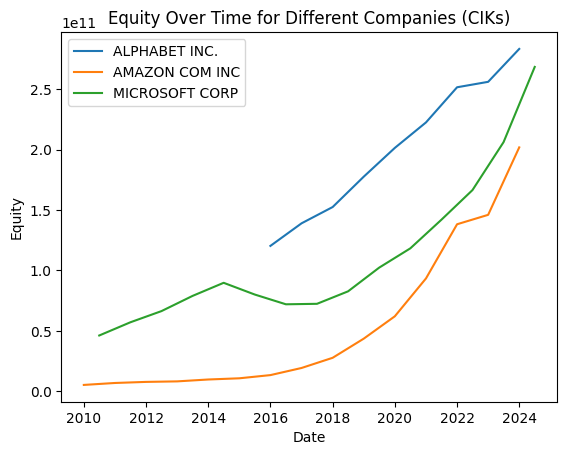

In [24]:
import matplotlib.pyplot as plt

# Group by 'name' and plot equity for each group
# Note: using the `present` method ensured that the same cik has always the same name even if the company name did change in the past
for name, group in standardized_bs_df.groupby('name'):
    plt.plot(group['date'], group['Equity'], label=name, linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Over Time for Different Companies (CIKs)')

# Display legend
plt.legend()

Now, let us use the Income Statement Standardizer and plot the GrossProfit:

2025-02-01 07:31:09,126 [INFO] standardizing  start PRE processing ...
2025-02-01 07:31:09,174 [INFO] standardizing  start MAIN processing ...
2025-02-01 07:31:09,914 [INFO] standardizing  start POST processing ...
2025-02-01 07:31:09,947 [INFO] standardizing  start FINALIZE ...


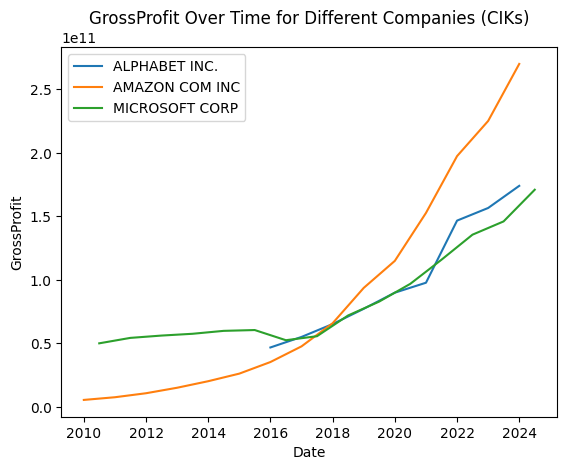

In [25]:
from secfsdstools.f_standardize.is_standardize import IncomeStatementStandardizer
    
standardizer = IncomeStatementStandardizer()
standardized_is_df = joined_bag.present(standardizer)

# sometimes, companies report in the annual report also the results for the last quarter itself. 
# To ensure, we use only the data for the whole year, we use only data that is for all 4 quarters
standardized_is_df = standardized_is_df[standardized_is_df.qtrs==4].copy()
    
import matplotlib.pyplot as plt

# Group by 'name' and plot equity for each group
# Note: using the `present` method ensured that the same cik has always the same name even if the company name did change in the past
for name, group in standardized_is_df.groupby('name'):
    plt.plot(group['date'], group['GrossProfit'], label=name, linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('GrossProfit')
plt.title('GrossProfit Over Time for Different Companies (CIKs)')

# Display legend
plt.legend()

And last, use the Cash Flow Standardizer to visualize the NetCashProvidedByUsedInOperatingActivities.

2025-02-01 07:32:02,648 [INFO] standardizing  start PRE processing ...
2025-02-01 07:32:02,729 [INFO] standardizing  start MAIN processing ...
2025-02-01 07:32:02,814 [INFO] standardizing  start POST processing ...
2025-02-01 07:32:02,862 [INFO] standardizing  start FINALIZE ...


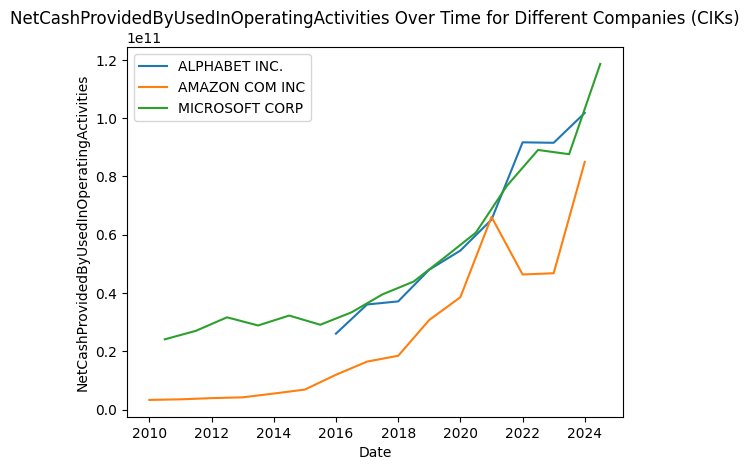

In [26]:
from secfsdstools.f_standardize.cf_standardize import CashFlowStandardizer
    
standardizer = CashFlowStandardizer()

standardized_cf_df = joined_bag.present(standardizer)

# sometimes, companies report in the annual report also the results for the last quarter itself. 
# To ensure, we use only the data for the whole year, we use only data that is for all 4 quarters
standardized_cf_df = standardized_cf_df[standardized_cf_df.qtrs==4].copy()

import matplotlib.pyplot as plt
# Group by 'name' and plot NetCashProvidedByUsedInOperatingActivities for each group
# Note: using the `present` method ensured that the same cik has always the same name even if the company name did change in the past
for name, group in standardized_cf_df.groupby('name'):
    plt.plot(group['date'], group['NetCashProvidedByUsedInOperatingActivities'], label=name, linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NetCashProvidedByUsedInOperatingActivities')
plt.title('NetCashProvidedByUsedInOperatingActivities Over Time for Different Companies (CIKs)')

# Display legend
plt.legend()

## What to do next
Definitely checkout the notebook "03_explore_with_interactive_notebook.ipynb" which shows some example on how the data can be explored in an interactive way in Jupyter.